In [1]:
# preparation
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from prml.rv import Gaussian, Uniform
from prml.sampling import metropolis, metropolis_hastings, rejection_sampling, sir

np.random.seed(1234)

对于大多数实际应用中的概率模型来说，精确推断是不可行的，因此我们不得不借助与某种形式的近似。在第10章中，我们讨论了基于确定性近似的推断方法，它包括诸如变分贝叶斯方法以及期望传播。这里，我们考虑基于数值采样的近似推断方法,也被称为蒙特卡罗（Monte Carlo）方法。
虽然对于一些应用来说，我们感兴趣的是非观测变量上的后验概率分布本身，但是在大部分情况下，后验概率分布的主要用途是计算期望，例如在做预测的情形下就是这样。因此，本章中，我们希望解决的基本的问题涉及到关于一个概率分布$ p(z) $寻找某个函数$ f(z) $的期望。这里，$ z $的元素可能是离散变量、连续变量或者二者的组合。因此，在连续变量的情形下，我们希望计算下面的期望
$ \mathbb{E}[f] = \int f(z)p(z)dz \tag{11.1} $
在离散变量的情形下，积分被替换为求和。图11.1图形化地说明了单一连续变量的情形。
 
图 11.1 函数$ f(z) $的期望的图形化表示，$ f(z) $的期望是关于概率分布$ p(z) $计算得到的。
我们假设，使用解析的方法精确地求出这种期望是十分复杂的。
采样方法背后的一般思想是得到从概率分布$ p(z) $中独立抽取的一组变量$ z(l) $，其中$ l = 1,...,L $。这使得期望可以通过有限和的方式计算，即
$ \hat{f} = \frac{1}{L}\sum\limits_{l=1}^L f(z^{(l)}) \tag{11.2} $
只要样本$ z^{(l)} $是从概率分布$ p(z) $中抽取的，那么$ \mathbb{E}[\hat{f}] = \mathbb{E}[f] $，因此估计$ \hat{f} $具有正确的均值。估计$ f $的方差为
$ var[\hat{f}] = \frac{1}{L}\mathbb{E}[(f - \mathbb{E}[f])^2] \tag{11.3} $
它是函数$ f(z) $在概率分布$ p(z) $下的方差。因此，值得强调的一点是，估计的精度不依赖于$ z $的维度，并且原则上，对于数量相对较少的样本$ z(l) $，可能会达到较高的精度。在实际应用中，10个或者20个独立的样本就能够以足够高的精度对期望做出估计。
然而，问题在于样本$ {z(l)} $可能不是独立的，因此有效样本大小可能远远小于表面上的样本大小。并且，回到图11.1，我们注意到如果$ f(z) $在$ p(z) $较大的区域中的值较小，反之亦然，那么期望可能由小概率的区域控制，表明为了达到足够的精度，需要相对较大的样本大小。
对于许多模型来说，联合概率分布$ p(z) $可以使用图模型很容易地确定。在没有观测变量的有向图的情形，从联合概率分布中采样是很容易的（假设可以从每个节点处的条件概率分布中采样），方法是使用8.1.2节简短讨论过的祖先采样方法（ancestral sampling approach）。联合概率分布为
$ p(z) = \prod\limits_{i=1}^Mp(z_i|pa_i) \tag{11.4} $
其中，$ z_i $是与结点$ i $关联的一组变量，$ pa_i $表示与结点$ i $的父结点关联的变量的集合。为了从联合概率分布中得到一个样本，我们按照$ z_1,...,z_M $的顺序遍历一次变量集合，这些变量是从条件概率分布$ p(z_i|pa_i) $中抽取的。这总是可行的，因为在每一步，所有的父结点的值都已经被初始化。在对图遍历一次之后，我们会得到来自联合概率分布的一个样本。
现在，考虑某些结点被观测值进行初始化的有向图的情形。原则上，我们可以推广上述的步骤，至少在结点表示离散变量的情形下我们可以这样做。对上述步骤的推广给出了逻辑采样（logic sampling）的方法（Henrion, 1988），它可以被看做11.1.4节讨论的重要采样（importance sampling）的一种特殊情况。在每一个步骤中，当我们得到了变量$ z_i $的一个采样值，它的值被观测，并且将采样值与观测值进行比较。如果它们相符，那么采样值被保留，算法继续运行，处理下一个变量。然而如果采样值与观测值不相符，那么目前为止得到的采样被丢弃，算法从图中的第一个结点重新开始。算法可以从后验概率分布中正确地采样，因为它对应于从隐含变量和数据变量的联合概率分布中采样然后丢弃那些与观测数据不相符的样本（稍微保留了一些从联合概率分布中采样的不连续性，只要观测到矛盾的值）。然而，接受一个来自后验概率分布的样本的整体概率会随着观测变量的数量的增加以及变量可以取得的状态数量的增加而迅速减小，因此这种方法在实际中很少被使用。
在由无向图定义的概率分布的情形中，如果我们希望从没有观测变量的先验概率分布中采样，那么不存在一遍采样的方法。相反，我们必须使用计算量更大的方法，例如11.3节讨论的吉布斯采样。
除了从条件概率分布中采样之外，我们可能也需要从边缘概率分布中采样。如果我们已经有 了一种从联合概率分布$ p(x, v) $中采样的方法，那么得到从边缘概率分布$ p(u) $中的样本是很容易的，只需忽略每个样本中的$ v $的值即可。
有许多讨论蒙特卡罗方法的文献。从统计推断的角度进行研究的文献包括Chen et al.(2001)、Gamerman(1997)、Liu(2001)、Neal(1996) 和Robert and Casella(1999)。并且有一些综述性的文章为统计推断的采样方法提供了额外的信息，例如Besag et al.(2005)、Brooks(1998)、Diaconis and Saloff-Coste(1998)、Jerrum and Sin- clair(1996)、Neal(1993)、Tierney(1994)和Andrieu et al.(2003)。
Robert and Casella(1999)总结了马尔科夫链蒙特卡罗算法的收敛性检测。




# 11.1 基本采样算法

本节中，我们研究从一个给定的概率分布中生成随机样本的一些简单的方法。由于样本是通过计算机算法生成的，因此这些样本实际上是伪随机数(pseudo-random numbers)，也就是说，它们通过计算的方法确定，但是仍然会通过随机性的检测。生成这种数字会产生一些微妙的性质(Press et al., 1992)，不在本书的讨论范围内。这里,我们假定算法生成的是$(0, 1) $之间均匀分布的伪随机数，事实上大部分软件开发环境都有这种功能。

## 11.1.1 标准概率分布

首先，我们考虑如何从简单的非均匀分布中生成随机数，假定我们已经有了一个均匀分布的随机数的来源。假设$ z $在区间$ (0, 1) $上均匀分布，我们使用某个函数$ f(\dot) $对$ z $的值进行变换，即$ y = f(z) $。$ y $上的概率分布为
$ p(y) = p(z)\left|\frac{dz}{dy}\right| \tag{11.5} $
其中，在这种情况下，$ p(z) = 1 $。我们的目标是选择一个函数$ f(z) $使得产生出的$ y $值具有某种所需的具体的分布形式$ p(y) $，对式（11.5）进行积分，我们有
$ z = h(y) \equiv \int_{-\infty}^y p(\hat{y})d\hat{y} \tag{11.6} $
它是$ p(y) $的不定积分。因此，$ y = h^{−1}(z) $，因此我们必须使用一个函数来对这个均匀分布的随机数进行变换，这个函数是所求的概率分布的不定积分的反函数，如图11.2所示。
 
图 11.2 生成非均匀分布的随机数的变换方法的几何表示。$ h(y) $是所求概率分布$ p(y) $的不定积分。如果一个均匀分布的随机变量$ z $使用$ y = h^{−1}(z) $进行变换，那么$ y $会服从概率分布$ p(y) $。
考虑指数分布（exponential distribution）
$ p(y) = \lambda exp(-\lambda y) \tag{11.7} $
其中$ 0 \leq y < \infty $。在这种情况下，式（11.6）的积分下界为0，因此$ h(y) = 1 − exp(−\lambda y) $。从而，如果我们将均匀分布的变量$ z $使用$ y = −\lambda^{−1} \ln(1 − z) $进行变换，那么$ y $就会服从指数分布。
另一种可以应用变换方法的概率分布是柯西分布
$ p(y) = \frac{1}{\pi}\frac{1}{1 + y^2} \tag{11.8} $
这种情况下，不定积分的反函数可以用$ \tan $函数表示。
对于多个变量情形的推广是很容易的，涉及到变量变化的Jacobian行列式，即
$ p(y_1,...,y_M) = p(z_1,...,z_M)\left|\frac{\partial(z_1,...,z_M)}{\partial(y_1,...,y_M)}\right| \tag{11.9} $
作为变换方法的最后一个例子，我们考虑Box-Muller方法,用于生成高斯概率分布的样本。首先，假设我们生成一对均匀分布的随机变量$ z_1,z_2 \in (−1,1) $，我们可以这样生成：对$ (0,1) $上的均匀分布的变量使用$ z \to 2z − 1 $的方式进行变换。接下来，我们丢弃那些不满足$ z_1^2 + z_2^2 \leq 1 $的点对。这产生出单位圆内部的一个均匀分布，且$ p(z_1, z_2) = 1 / pi $，如图11.3所示。
 
图 11.3 Box-Muller方法用于生成高斯分布的随机数，方法在开始时使用的是单位圆内部均匀分布的样本。
然后，对于每对$ z_1, z _2 $，我们计算
$ \begin{eqnarray} y_1 &=& z_1\left(\frac{-2\ln r^2}{r^2}\right)^{1/2} \tag{11.10} \ y_2 &=& z_2\left(\frac{-2\ln r^2}{r^2}\right)^{1/2} \tag{11.11} \end{eqnarray} $
其中$ r^2 = z_1^2 + z_2^2 $。这样，$ y_1, y_2 $的联合概率分布为
$ \begin{eqnarray} p(y_1,y_2) &=& p(z_1,z_2)\left|\frac{\partial(z_1,z_2)}{\partial(y_1,y_2)}\right| \ &=& \left[\frac{1}{\sqrt{2\pi}}exp\left(\frac{-y_1^2}{2}\right)\right]\left[\frac{1}{\sqrt{2\pi}}exp\left(\frac{-y_2^2}{2}\right)\right] \tag{11.12} \end{eqnarray} $
因此$ y_1, y_2 $是独立的，且每个都服从高斯分布，均值为0，方差为1。
如果$ y $服从高斯分布，且均值为0，方差为1，那么$ \sigma y + \mu $也服从高斯分布，均值为$ \mu $，方差为$ \sigma^2 $。为了生成向量值的变量，且这个变量服从多元高斯分布，均值为$ \mu $，协方差为$ \Sigma $，我们可以使用Cholesky分解，它的形式为$ \Sigma = LL^T $（Press et al., 1992）。这样，如果$ z $是一个向量值的随机变量，且它的元素是独立的，并且服从均值为0、方差为1的高斯分布，那么$ y = \mu + Lz $的均值为$ \mu $，协方差为$ \Sigma $。
显然，变换方法依赖于它能够进行计算所需的概率分布，并且能够求所需的概率分布的不定积分的反函数。这样的计算只对于一些非常有限的简单的概率分布可行，因此我们必须寻找一些更加一般的方法。这里，我们考虑两种方法，即拒绝采样（rejection sampling）和重要采样（importance sampling）。虽然这些方法主要限制在单变量概率分布，因此无法直接应用于多维的复杂问题，但是这些方法确实是更一般的方法的重要成分。



## 11.1.2 拒绝采样

拒绝采样框架使得我们能够在满足某些限制条件的情况下，从相对复杂的概率分布中采样。首先，我们考虑单变量分布，然后接下来讨论对于多维情形的推广。
假设我们希望从概率分布$ p(z) $中采样，这个概率分布不是我们目前为止讨论过的简单的标准的概率分布中的一个，从而直接从$ p(z) $中采样是很困难的。此外，正如经常出现的情形那样，我们假设我们能够很容易地计算对于任意给定的$ z $值的$ p(z) $（不考虑标准化常数$ Z $），即
$ p(z) = \frac{1}{Z_p}\tilde{p}(z) \tag{11.13} $
其中$ \tilde{p}(z) $可以很容易地计算，但$ Z_p $未知。
为了应用拒绝采样方法，我们需要一些简单的概率分布$ q(z) $，有时被称为提议分布（proposal distribution），并且我们已经可以从提议分布中进行采样。接下来，我们引入一个常数$ k $，它的值的选择满足下面的性质：对所有的$ z $值，都有$ kq(z) \geq \tilde{p}(z) $。函数$ kq(z) $被称为比较函数，且图11.4给出了单变量概率分布的说明。
 
图 11.4 在拒绝采样的方法中，样本从一个简单的概率分布$ q(z) $中抽取。如果样本落到了未标准化的概率分布$ \tilde{p}(z) $与放缩的概率分布$ kq(z) $之间的灰色区域，那么样本会被拒绝。得到的样本服从$ p(z) $的分布，它是$ \tilde{p}(z) $的归一化版本。
拒绝采样器的每个步骤涉及到生成两个随机数。首先，我们从概率分布$ q(z) $中生成一个数$ z_0 $。接下来，我们在区间$ [0, kq(z_0)] $上的均匀分布中生成一个数$ u_0 $。这对随机数在函数$ kq(z) $的曲线下方是均匀分布。最后，如果$ u_0 > \tilde{p}(z_0) $，那么样本被拒绝，否则$ u_0 $被保留。因此，如果它位于图11.4的灰色阴影部分，它就会被拒绝。这样，剩余的点对在曲线$ \tilde{p}(z) $下方是均匀分布的，因此对应的$ z $值服从概率分布$ p(z) $，正如我们所需的那样。
$ z $的原始值从概率分布$ q(z) $中生成，这些样本之后被接受的概率为$ \tilde{p}(z) / kq(z) $，因此一个样本会被接受的概率为
$ \begin{eqnarray} p(accept) &=& \int\left{\frac{\tilde{p}(z)}{kq(z)}\right}q(z)dz \ &=& \frac{1}{k}\int\tilde{p}(z)dz \tag{11.14} \end{eqnarray} $
因此，被这种方法拒绝的点的比例依赖于曲线$ kq(z) $下方的未标准化概率分布$ \tilde{p}(z) $的面积的比例。于是，我们看到，常数$ k $应该尽量小，同时满足下面的限制条件：$ kq(z) $一定处处不小于$ \tilde{p}(z) $。
作为拒绝采样的一个例子，我们考虑从Gamma分布中采样的任务，Gamma分布的形式为
$ Gam(z|a,b) = \frac{b^az^{a-1}exp(-bz)}{\Gamma(a)} \tag{11.15} $
对于$ a > 1 $的情形，它的形状是钟形曲线，如图11.5所示。
于是，一个合适的提议分布为柯西分布（11.8），因为这个分布也是一个钟形曲线，并且因为我们可以使用之前讨论的变换方法从这个分布中进行采样。我们需要对柯西分布稍稍进行推广，来确保它处处的值都不小于Gamma分布。可以这样做：对一个均匀分布的变量$ y $，使用$ z = b \tan y + c $进行变换，它给出了服从概率分布：
$ q(z) = \frac{k}{1 + \frac{(z - c)^2}{b^2}} \tag{11.16} $
的随机数。最小的拒绝率在下面的条件下得到：令$ c = a − 1, b^2 = 2a − 1 $，并且将常数$ k $选得尽可能小，同时满足$ kq(z) \geq \tilde{p}(z) $的要求。函数的对比也在图11.5中给出。
 
图 11.5 绿色曲线表示式（11.15）给出的Gamma分布的图像，红色曲线表示放缩后的柯西提议分布。从Gamma分布中抽取的样本可以通过从柯西分布中采样然后使用拒绝采样准则的方法得到。



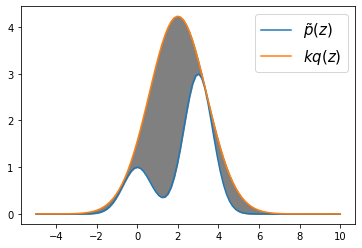

In [2]:
# plot
def func(x):
    return np.exp(-x ** 2) + 3 * np.exp(-(x - 3) ** 2)
x = np.linspace(-5, 10, 100)
rv = Gaussian(mu=np.array([2.]), var=np.array([2.]))
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.plot(x, 15 * rv.pdf(x), label=r"$kq(z)$")
plt.fill_between(x, func(x), 15 * rv.pdf(x), color="gray")
plt.legend(fontsize=15)
plt.show()

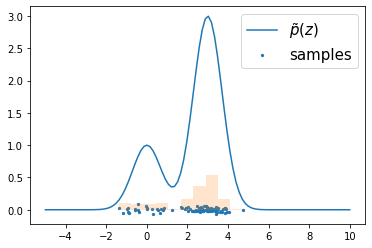

In [3]:
# plot
samples = rejection_sampling(func, rv, k=15, n=100)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()

## 11.1.3 可调节的拒绝采样

在许多我们希望应用拒绝采样的情形中，确定概率分布$ q(z) $的一个合适的解析形式是很困难的。另一种确定其函数形式的方法是基于概率分布$ p(z) $的值直接构建函数形式（Gilks and Wild, 1992）。对于$ p(z) $是对数凹函数的情形，即$ \ln p(z) $的导数是$ z $的单调非增函数时，界限函数的构建是相当简单的。图11.6给出了一个合适的界限函数的构建的例子。
 
图 11.6 在对数凹函数的情形下，拒绝采样中用到的界限函数可以使用在一组格点处计算的切线来构造。如果一个样本点被拒绝，那么它被添加到格点集合中，被用于优化界限函数。
函数$ \ln p(z) $和它的切线在某些初始的格点处进行计算，生成的切线的交点被用于构建界限函数。接下来，我们从界限分布中抽取一个样本值。这很容易，因为界限函数的对数是一系列的线性函数，因此界限函数本身由一个分段指数分布组成，形式为
$ q(z) = k_i\lambda_i exp{-\lambda_i(z-z_i)} \hat{z}{i - 1, i} < z \leq \hat{z}{i,i+1} \tag{11.17} $
其中$ \hat{z}{i - 1, i} $是在点$ z{i - 1} $和$ z_i $处的切线的交点，$ \lambda_i $是切线在$ z_i $处的斜率，$ k_i $表示对应的偏移量。一旦一个样本点被抽取完毕，我们就可以应用通常的拒绝准则了。如果样本被接受，那么它就是所求的概率分布中的一个样本。然而，如果样本被拒绝，那么它被并入格点的集合中，计算出一条新的切线，从而界限函数被优化。随着格点数量的增加，界限函数对所求的概率分布的近似效果逐渐变好，拒绝的概率就会减小。
这个算法存在一种变体，这种变体中不用计算导数（Gilks, 1992）。可调节的拒绝采样的框架也可以扩展到不是对数凹函数的概率分布中，只需将每个拒绝采样的步骤中使用Metropolis-Hasting阶梯函数（将在11.2.2节讨论）即可，这就产生了可调节拒绝Metropolis采样（adaptive rejection Metropolis sampling）方法（Gilks et al., 1995）。
显然，对于具有实际价值的拒绝采样来说，我们要求对比函数要接近所求的概率分布，从而拒绝率要保持一个最小值。现在，让我们考察当我们试图在高维空间中使用拒绝采样的方法会出现什么现象。为了说明的方便，考虑一个多少有些人造感觉的问题，其中我们想要从一个零均值多元高斯分布中采样，这个高斯分布的协方差为$ \sigma_p^2I $，其中$ I $是单位矩阵。根据拒绝采样方法，提议分布本身就是一个均值为0，协方差为$ \sigma_q^2I $的高斯分布。很明显，为了使$ kq(z) \geq p(z) $的$ k $值存在，我们必须有$ \sigma_q^2 \geq \sigam_p^2 $。在D维的情形中，$ k $的值为$ k = \left(\frac{\sigma_q}{\sigma_p}\right)^D $，图11.7给出了$ D = 1 $的情形。接受率是$ p(z) $和$ kq(z) $下方的体积的比值。由于分布是标准化的，这个比值就是$ 1 / k $。因此，接受率随着维度的增大而指数地减小。即使$ \sigma_q $只比$ \sigma_p $高一个百分点，对于$ D = 1000 $，接受率大约为$ 1 / 20,000 $。在这个说明的例子中，对比函数接近于所求的概率分布。对于更实际的例子来说，所求的概率分布可能是多峰的，并且具有尖峰，从而找到一个较好的提议分布和比较函数是一件相当困难的事情。此外，接受率随着维度的指数下降是拒绝采样的一个一般特征。虽然拒绝采样在一维或二维空间中是一个有用的方法，但是它不适用于高维空间。然而，对于高维空间中的更加复杂的算法来说，它起着子过程的作用。



## 11.1.4 重要采样

想从复杂概率分布中采样的一个主要原因是能够使用式（11.1）计算期望。重要采样（importance sampling）的方法提供了直接近似期望的框架，但是它本身并没有提供从概率分布$ p(z) $中采样的方法。
式（11.2）给出的期望的有限和近似依赖于能够从概率分布$ p(z) $中采样。然而，假设直接从$ p(z) $中采样无法完成，但是对于任意给定的$ z $值，我们可以很容易地计算$ p(z) $。一种简单的计算期望的方法是将$ z $空间离散化为均匀的格点，将被积函数使用求和的方式计算，形式为
$ \mathbb{E}[f] \simeq \sum\limits_{l=1}^Lp(z^{(l)})f(z^{(l)}) \tag{11.18} $
这种方法的一个明显的问题是求和式中的项的数量随着$ z $的维度指数增长。此外，正如我们已经注意到的那样，我们感兴趣的概率分布通常将它们的大部分质量限制在$ z $空间的一个很小的区域，因此均匀地采样非常低效，因为在高维的问题中，只有非常小的一部分样本会对求和式产生巨大的贡献。我们希望从$ p(z) $的值较大的区域中采样，或理想情况下，从$ p(z)f(z) $的值较大的区域中采样。
与拒绝采样的情形相同，重要采样基于的是对提议分布$ q(z) $的使用，我们很容易从提议分布中采样，如图11.8所示。
 
图 11.8 重要采样解决了计算函数$ f(z) $关于分布$ p(z) $的期望的问题，其中，从$ p(z) $中直接采样比较困难。相反，样本$ {z^{(l)}} $从一个简单的概率分布$ q(z) $中抽取，求和式中的对应项的权值为$ p(z^{(l)})/q(z^{(l)}) $。
之后，我们可以通过$ q(z) $中的样本$ {z(l)} $的有限和的形式来表示期望
$ \begin{eqnarray} \mathbb{E} &=& \int f(z)p(z)dz \ &=& \int f(z)\frac{p(z)}{q(z)}q(z)dz \ &\simeq& \frac{1}{L}\sum\limits_{l=1}^L\frac{p(z^{(l)})}{q(z^{(l)})}f(z^{(l)}) \tag{11.19} \end{eqnarray} $
其中$ r_l = p(z^{(l)}) / q(z^{(l)}) $被称为重要性权重（importance weights），修正了由于从错误的概率分布中采样引入的偏差。注意，与拒绝采样不同，所有生成的样本都被保留。
常见的情形是，概率分布$ p(z) $的计算结果没有标准化，即$ p(z) = \tilde{p}(z) / Z_p $，其中$ \tilde{p}(z) $可以很容易地计算出来，而$ Z_p $未知。类似的，我们可能希望使用重要采样分布$ q(z) = \tilde{q}(z) / Z_q $，它具有相同的性质。于是我们得到
$ \begin{eqnarray} \mathbb{E}[f] &=& \int f(z)p(z)dz \ &=& \frac{Z_q}{Z_p}\int f(z)\frac{\tilde{p}(z)}{\tilde{q}(z)}q(z)dz \ &\simeq& \frac{Z_q}{Z_p}\frac{1}{L}\sum\limits_{l=1}^L\tilde{r}_lf(z^{(l)}) \tag{11.20} \end{eqnarray} $
其中$ \tilde{r}_l = \tilde{p}(z^{(l)}) / \tilde{q}(z^{(l)}) $。我们可以使用同样的样本集合来计算比值$ Z_p / Z_q $，结果为
$ \begin{eqnarray} \frac{Z_p}{Z_q} &=& \frac{1}{Z_q}\int\tilde{p}(z)dz = \int\frac{\tilde{p}(z)}{\tilde{q}(z)}q(z)dz \ &\simeq& \frac{1}{L}\sum\limits_{l=1}^L\tilde{r}_l \tag{11.21} \end{eqnarray} $
因此
$ \mathbb{E}[f] \simeq \sum\limits_{l=1}^Lw_lf(z^{(l)}) \tag{11.22} $
其中我们已经定义
$ w_l = \frac{\tilde{r}_l}{\sum_m\tilde{r}_m} = \frac{\tilde{p}(z^{(l)})/q(z^{(l)})}{\sum_m\tilde{p}(z^{(l)})/q(z^{(l)})} \tag{11.23} $
与拒绝采样的情形相同，重要采样方法的成功严重依赖于采样分布$ q(z) $与所求的概率分布$ p(z) $的匹配程度。经常出现的情形是$ p(z) $变化剧烈，且大部分的质量集中于z空间的一个相对较小的区域中，此时重要性权重$ {r_l} $由几个具有较大值的权值控制，剩余的权值相对较小。因此，有效的样本集大小会比表面上的样本集大小$ L $小得多。如果没有样本落在$ p(z)f(z) $较大的区域中，那么问题会更加严重。此时，$ r_l $和$ r_lf(z^{(l)}) $的表面上的方差可能很小，即使期望的估计可能错得离谱。因此，重要性采样方法的一个主要的缺点是它具有产生任意错误的结果的可能性，并且这种错误无法检测。这也强调了采样分布$ q(z) $的一个关键的要求，即它不应该在$ p(z) $可能较大的区域中取得较小的值或为0的值。
对于根据图模型定义的概率分布，我们可以用多种方式使用重要采样。对于离散变量，一个简单的方法被称为均匀采样（uniform sampling）。有向图的联合概率分布由式（11.4）定义。联合概率分布中的每个样本都按照下面的方式获得：首先令证据集合中的变量$ z_i $等于它们的观测值。之后，每个剩余的变量从可能的实例空间中的均匀分布中独立地抽取。为了确定与一个样本$ z^{(l)} $相关联的对应的权值，我们注意到采样分布$ \tilde{q}(z) $是$ z $的可能选择上的均匀分布，且$ \tilde{p}(z|x) = \tilde{p}(z) $，其中$ x $表示观测变量的子集，等式来源于下面的事实：每个产生的样本$ z $都与证据相容。因此，权值$ r_l $简单地正比于$ p(z) $。注意，变量可以以任意顺序采样。如果后验概率分布与均匀分布的差距较大，那么这种方法会产生较差的结果，而这正是实际应用中经常出现的情形。
这种方法的一个重要的提升被称为似然加权采样（likelihood weighted sampling）（Fung and Chang,1990; Shachter and Peot,1990)，基于对变量的祖先采样。反过来对于每个变量，如果变量在证据集合中，那么它被简单地设置为它的实例值。如果它没在证据集合中，那么它从条件 概率分布$ p(z_i| pa_i) $中采样，其中条件变量被设置为它们当前的采样值。于是，与最终的样本$ z $关联的权值为
$ r(z) = \prod\limits_{z_i \not\in e}\frac{p(z_i|pa_i)}{p(z_i|pa_i)}\prod\limits_{z_i \in e}\frac{p(z_i|pa_i)}{1} = \prod\limits_{z_i \in e}p(z_i|pa_i) \tag{11.24} $
这种方法可以进一步扩展，使用自重要采样（self-importance sampling）（Shachter and Peot, 1990），其中重要采样分布连续地更新，反映当前估计的后验概率分布。



## 11.1.5 采样-重要性-重采样

11.1.2节讨论的拒绝采样方法部分依赖于它能够成功确定常数k的一个合适的值。对于许多对概率分布$ p(z) $和$ q(z) $来说，确定一个合适的$ k $值是不现实的，因为任意的足够大的$ k $值都能够保证产生所求的分布的上界，但是这会产生相当小的接受率。
与拒绝采样的情形相同，采样-重要-再采样（sampling-importance-resampling, SIR）方法也使用采样分布$ q(z) $，但是避免了必须确定常数$ k $。这个方法有两个阶段。在第一个阶段，$ L $个样本$ z^{(1)},...,z^{(L)} $从$ q(z) $中抽取。然后在第二个阶段，权值$ w_1,...,w_L $通过式（11.23）被构建出来。最后，$ L $个样本的第二个集合从离散概率分布$ (z^{(1)},...,z^{(L)}) $中抽取，概率由权值$ (w_1,...,w_L) $给定。
生成的$ L $个样本只是近似地服从$ p(z) $，但是在极限$ L \to \infty $的情况下，分布变为了正确的分布。为了说明这一点，考虑一元变量的情形，并且注意重新采样的值的累积分布为
$ \begin{eqnarray} p(z \leq a) &=& \sum\limits_{l:z^{(l)} \leq a}w_l \ &=& \frac{\sum_lI(z^{(l) \leq a})\tilde{p}(z^{(l)})/q(z^{(l)})}{\sum_l \tilde{p}(z^{(l)}) / q(z^{(l)})} \tag{11.25} \end{eqnarray} $
其中$ I(\dot) $是示性函数（参数为真时函数值为1，否则为0）。取极限$ L \to \infty $，并且假设概率分布进行了适当的正则化，我们可以将求和替换为积分，权值为原始的采样分布$ q(z) $，即
$ \begin{eqnarray} p(z \leq a) &=& \frac{\int I(z \leq a){\tilde{p}(z) / q(z)}q(z)dz}{\int{\tilde{p}(z) / q(z)}q(z)dz} \ &=& \frac{\int I(z\leq a)\tilde{p}(z)dz}{\int\tilde{p}(z)dz} \ &=& \int I(z \leq a)p(z)dz \tag{11.26} \end{eqnarray} $
它是$ p(z) $的累积分布函数。同样的，我们看到对$ p(z) $的标准化是不需要的。
对于$ L $的一个有限值，以及一个给定的初始样本集合，重新采样的值只是近似地从所求的概率分布中抽取。与拒绝采样的情形相同，随着样本分布$ q(z) $接近所求的分布$ p(z) $，近似的效果也会提升。当$ q(z) = p(z) $时，初始样本$ (z^{(1)},...,z^{(L)}) $服从所求的概率分布，权值为$ w_n = 1/L $，从而重新采样的值也服从所求的分布。
$ L $如果我们需要求出关于概率分布$ p(z) $的各阶矩，那么可以直接使用原始样本和权值进行计算，因为
$ \begin{eqnarray} \mathbb{E}[f(z)] &=& \int f(z)p(z)dz \ &=& \frac{f(z)[\tilde{p}(z) / q(z)]q(z)dz}{\int[\tilde{p}(z)/q(z)]q(z)dz} \ &=& \sum\limits_{l=1}^Lw_lf(Z_l) \tag{11.27} \end{eqnarray} $



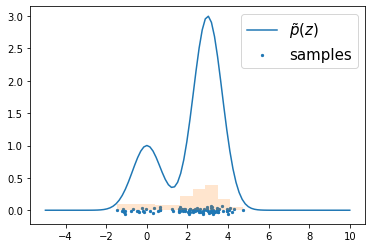

In [4]:
# plot
samples = sir(func, rv, n=100)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()

## 11.1.6 采样与EM算法

蒙特卡罗方法除了为贝叶斯框架的直接实现提供了原理，还在频率学家的框架内起着重要的作用，例如寻找最大似然解。特别地，对于EM算法中的E步骤无法解析地计算的模型，采样方法也可以用来近似E步骤。考虑一个模型，它的隐含变量为$ Z $，可见（观测）变量为$ X $，参数 为$ \theta $。在M步骤中关于$ \theta $最大化的步骤为完整数据对数似然的期望，形式为
$ Q(\theta,\theta^{old}) = \int p(Z|X,\theta^{old})\ln p(Z,X|\theta)dZ \tag{11.28} $
我们可以使用采样方法来近似这个积分，方法是计算样本$ {Z^{(l)}} $上的有限和，这些样本是从当前的对后验概率分布$ p(Z|X, θ^{old}) $的估计中抽取的，即
$ Q(\theta,\theta^{old}) \simeq \frac{1}{L}\sum\limits_{l=1}^L\ln p(Z^{(l)},X|\theta) \tag{11.29} $
然后，$ Q $函数在M步骤中使用通常的步骤进行优化。这个步骤被称为蒙特卡罗EM算法（Monte Carlo EM algorithm）。
将这种方法推广到寻找$ \theta $上的后验概率的峰值（MAP估计）的问题是很容易的，其中先验概率分布$ p(\theta) $已经被定义。我们只需在进行M步骤之前，在函数$ Q(\theta, \theta^{old}) $中加上$ \ln p(\theta) $即可。
蒙特卡罗EM算法的一个特定的情形，被称为随机EM（stochastic EM）。如果我们考虑有限数量的概率分布组成的混合模型，并且在每个E步骤中只抽取一个样本时，我们就会用到这种算法。这里，潜在变量$ Z $描述了$ K $个混合分量中的哪个分量被用于生成每个数据点。在E步骤中，$ Z $的样本从后验概率分布$ p(Z|X, \theta^{old}) $中抽取，其中X是数据集。这高效地将每个数据点硬性地分配到混合分布中的一个分量中。在M步骤中，对于后验概率分布的这个采样的近似被用于按照平常的方式更新模型的参数。
现在假设我们从最大似然的方法转移到纯粹的贝叶斯方法，其中我们希望从参数向量$ \theta $上的后验概率分布中进行采样。原则上，我们希望从联合后验分布$ p(\theta, Z|X) $中抽取样本，但是我们假设这个计算十分困难。进一步的，我们假设从完整数据参数的后验概率分布$ p(\theta|Z,X) $中进行采样相对简单。这就产生了数据增广算法（data augmentation algorithm），它在两个步骤之间交替进行，这两个步骤被称为I步骤（归咎(imputation)步骤，类似于E步骤）和P步骤（后验(posterior)步骤，类似于M步骤）。
I步骤。我们希望从概率分布$ p(Z|X) $采样，但是我们不能直接进行。于是，我们注意到下面的关系
$ p(Z|X) = \int p(Z|\theta,X)p(\theta|X)d\theta \tag{11.30} $
因此对于$ l = 1,...,L $，我们首先从当前对$ p(\theta|X) $的估计中抽取样本$ \theta^{(l)} $，然后使用这个样本从$ p(Z|\theta^{(l)}, X) $中抽取样本$ Z^{(l)} $。
P步骤。给定关系
$ p(\theta|X) = \int p(\theta|Z,X)p(Z|X)dZ \tag{11.31} $
我们使用从I步骤中得到的样本$ {Z^{(l)}} $，计算$ \theta $上的后验概率分布的修正后的估计，结果为
$ p(\theta|X) \simeq \frac{1}{L}\sum\limits_{l=1}^Lp(\theta|Z^{(l)},X) \tag{11.32} $
根据假设，在I步骤中从这个近似分布中采样是可行的。
注意，我们对参数$ \theta $和隐含变量$ Z $进行了（多少有些人为的）区分。从现在开始，我们不进行这种区分，仅仅集中于从给定的后验概率分布中抽取样本的问题。



# 11.2 马尔可夫链蒙特卡洛

前一节中，我们讨论了计算函数期望的拒绝采样方法和重要采样方法，我们看到在高维空间中，这两种方法具有很大的局限性。因此，我们在本节中讨论一个非常一般的并且强大的框架，被称为马尔科夫链蒙特卡罗（Markov chain Monte Carlo， MCMC），它使得我们可以从一大类概率分布中进行采样，并且可以很好地应对样本空间维度的增长。马尔科夫链蒙特卡罗方法起源于物理学（Metropolis and Ulam， 1949），直到20世纪80年代，这种方法才开始对统计学领域产生巨大的影响。
与拒绝采样和重要采样相同，我们再一次从提议分布中采样。但是这次我们记录下当前状 态$ z^{(\tau)} $，以及依赖于这个当前状态的提议分布$ q(z|z^{(\tau)}) $，从而样本序列$ z^{(1)}，z^{(2)},... $组成了一个马尔科夫链。同样的，如果我们有$ p(z) = \tilde{p}(z) / Z_p $，那么我们会假定对于任意的$ z $值都可以计算$ \tilde{p}(z) $，虽然$ Z_p $的值可能位置。提议分布本身被选择为足够简单，从而直接采样很容易。在算法的每次迭代中，我们从提议分布中生成一个候选样本$ z^* $，然后根据一个恰当的准则接受这个样本。
在基本的Metropolis算法中(Metropolis et al.， 1953)，我们假定提议分布是对称的，即$ q(z_A|z_B) = q(z_B|z_A) $对于所有的$ z_A $和$ z_B $成立。这样，候选的样本被接受的概率为
$ A(z^, z^{(\tau)} = \min\left(1, \frac{\tilde{p}(z^)}{\tilde{p}(z^{(\tau)})}\right) \tag{11.33} $
可以这样实现：在单位区间$ (0，1) $上的均匀分布中随机选择一个数$ u $，然后如果$ A(z^, z^{(\tau)}) > u $就接受这个样本。注意，如果从$ z^\tau $到$ z^ $引起了$ p(z) $的值的增大，那么这个候选样本当然会被保留。
如果候选样本被接受，那么$ z^{(τ+1)} = z^* $，否则候选样本点$ z^* $被丢弃，$ z^{(\tau+1)} $被设置为$ z^{(\tau)} $，然后从概率分布$ q(z|z^{(\tau+1)}) $中再次抽取一个候选样本。这与拒绝采样不同，那里拒绝的样本被简单地丢弃。在Metropolis算法中，当一个候选点被拒绝时，前一个样本点会被包含到最终的样本的列表中，从而产生了样本点的多个副本。当然，在实际实现中，每个保留的样本只会有一个副本，以及一个整数的权因子，记录状态出现了多少次。正如我们将看到的那样，只要对于任意的$ z_A $和$ z_B $都有$ q(z_A|z_B) $为正（这是一个充分条件但不是必要条件），那么当$ \tau \to \infty $时，$ z(\tau) $趋近于$ p(z) $。然而，应该强调的是，序列$ z^{(1)}, z^{(2)},... $不是来自$ p(z) $的一组独立的样本，因为连续的样本是高度相关的。如果我们希望得到独立的样本，那么我们可以丢弃序列中的大部分样本，每个样本中保留一个样本。对于充分大的$ M $，保留的样本点对于所有的实际用途来说都是独立的。图11.9给出了一个简单的例子，这个例子使用Metropolis算法从一个二维高斯分布中采样，其中提议分布是一个各向同性的高斯分布。
 
图 11.9 使用Metropolis算法从一个高斯分布中采样的简单例子，这个高斯分布的一个标准差的位置用椭圆表示。提议分布是一个各向同性的高斯分布，标准差为0.2。被接受的步骤用绿线表示，被拒绝的步骤用红线表示。总共生成了150个候选样本，其中有43个被拒绝。
通过考察一个具体的例子，即简单的随机游走的例子，我们可以对马尔科夫链蒙特卡罗算法的本质得到更深刻的认识。考虑一个由整数组成的状态空间z，概率为
$ \begin{eqnarray} p(z^{(\tau + 1)} = z^{(\tau)}) &=& 0.5 \tag{11.34} \ p(z^{(\tau + 1)} = z^{(\tau)} + 1) &=& 0.25 \tag{11.35} \ p(z^{(\tau + 1)} = z^{(\tau)} - 1) &=& 0.25 \tag{11.36} \end{eqnarray} $
其中$ z^{(τ)} $表示在步骤$ \tau $的状态。如果初始状态是$ z^{(0)} = 0 $，那么根据对称性，在时刻$ \tau $的期望状态也是0，即$ \mathbb{E}[z^{(τ)}] = 0 $，类似地很容易看到$ \mathbb{E}[(z^{(\tau)})^2] = \tau / 2 $。因此，在$ \tau $步骤之后，随机游走所经过的平均距离正比于$ \tau $的平方根。这个平方根依赖关系是随机游走行为的一个典型性质，表明了随机游走在探索状态空间时是很低效的。正如我们会看到的那样，设计马尔科夫链蒙特卡罗方法的一个中心目标就是避免随机游走行为。



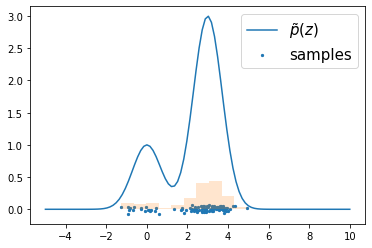

In [5]:
# plot
samples = metropolis(func, Gaussian(mu=np.zeros(1), var=np.ones(1)), n=100, downsample=10)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()

## 11.2.1 马尔可夫链

在详细讨论马尔科夫链蒙特卡罗方法之前，仔细研究马尔科夫链的一些一般的性质是很有用的。特别的，我们考察在什么情况下马尔科夫链会收敛到所求的概率分布上。一阶马尔科夫链被定义为一系列随机变量$ z^{(1)},...,z^{(M)} $，使得下面的条件独立性质对于$ m \in {1,...,M−1} $成立
$ p(z^{(m+1)}|z^{(1)},...,z^{(m)}) = p(z^{(m+1)}|z^{(m)}) \tag{11.37} $
这当然可以表示成链形的有向图，如图8.38所示。之后，我们可以按照下面的方式具体化一个马尔科夫链：给定初始变量的概率分布$ p(z^{(0)}) $，以及后续变量的条件概率，用转移概率（transition probability）$ T_m(z^{(m)}, z^{(m+1)}) \equiv p(z^{(m+1)} | z^{(m)}) $的形式表示。如果对于所有的$ m $，转移概率都相同，那么这个马尔科夫链被称为同质的（homogeneous）。
对于一个特定的变量，边缘概率可以根据前一个变量的边缘概率用链式乘积的方式表示出来，形式为
$ p(z^{(m+1)}) = \sum\limits_{z^{(m)}} p(z^{(m+1)}|z^{(m)})p(z^{(m)}) \tag{11.38} $
那么概率分布$ p^*(z) $是不变的。注意，一个给定的马尔科夫链可能有多个不变的概率分布。例如，如果转移概率由恒等变换给出，那么任意的概率分布都是不变的。
确保所求的概率分布$ p(z) $不变的一个充分（非必要）条件是令转移概率满足细节平衡（detailed balance）性质，定义为
$ p^(z)T(z,z') = p^(z')T(z',z) \tag{11.40} $
对特定的概率分布$ p^*(z) $成立。很容易看到，满足关于特定概率分布的细节平衡性质的转移概率会使得那个概率分布具有不变性，因为
$ \sum\limits_{z'}p^(z')T(z',z) = \sum\limits_{z'}p^(z)T(z,z') = p^(z)\sum\limits_{z'}p(z'|z) = p^(z) \tag{11.41} $
满足细节平衡性质的马尔科夫链被称为可翻转的（reversible）。
我们的目标是使用马尔科夫链从一个给定的概率分布中采样。如果我们构造一个马尔科夫链使得所求的概率分布是不变的，那么我们就可以达到这个目标。然而，我们还要要求对于$ m \to \infty $，概率分布$ p(z^{(m)}) $收敛到所求的不变的概率分布$ p^*(z) $，与初始概率分布$ p(z^{(0)}) $无关。这种性质被称为各态历经性（ergodicity），这个不变的概率分布被称为均衡（equilibrium）分布。很明显，一个具有各态历经性的马尔科夫链只能有唯一的一个均衡分布。可以证明，同质的马尔科夫链具有各态历经性，只需对不变的概率分布和转移概率做出较弱的限制即可（Neal, 1993）。
在实际中，我们经常可以从一组“基”转移$ B_1,...,B_K $中构建转移概率，方法为：将各个“基”转移表示为混合概率分布，形式为
$ T(z',z) = \sum\limits_{k=1}^K\alpha_kB_k(z',z) \tag{11.42} $
混合系数$ \alpha_1,...,\alpha_K $满足$ \alpha_k \geq 0 $且$ \sum_k\alpha_k = 1 $。此外，基转移可以通过连续的应用组合到一起，即
$ T(z',z) = \sum\limits_{z_1}\dots\sum\limits_{z_{K-1}}B_1(z',z_1)\dots B_{K-1}(z_{K-2},z_{K-1})B_K(z_{K-1},z) \tag{11.43} $
如果一个概率分布关于每个基转移都是不变的，那么显然它关于式（11.42）和（11.43）也是不变的。对于式（11.42）的混合分布，如果每个基转移满足细节平衡，那么混合转移$ T $也满足细节平衡。这对于使用式（11.43）构造的转移概率不成立，虽然通过将基转移的顺序对称化，即采用$ B_1, B_2,...,B_K, B_K,...,B_2, B_1 $的形式，细节平衡的性质可以被恢复。使用组合转移概率的一个常见的例子是每个基转移只改变变量的一个子集的情形。



## 11.2.2 Metropolis-Hastings 算法

之前我们介绍了基本的Metropolis算法，没有实际演示它从所求的概率分布中采样的过程。在给出一个证明之前，我们首先讨论一个推广，被称为Metropolis-Hastings算法(Hastings，1970)，这种情形下，提议分布不再是参数的一个对称函数。特别地，在算法的步骤$ \tau $中，当前状态为$ z(\tau) $，我们从概率分布$ q_k(z|z^{(\tau)}) $中抽取一个样本$ z^* $，然后以概率$ A_k(z^*，z^{(\tau)}) $接受它， 其中
$ A_k(z^，z^{(\tau)}) = \min\left(1, \frac{\tilde{p}(z^)q_k(z^{(\tau)}|z^)}{\tilde{p}(z^{(\tau)}q_k(z^|z^{(\tau)}))}\right) \tag{11.44} $
这里，$ k $标记出可能的转移集合中的成员。与之前一样，接受准则的计算不需要知道概率分布$ p(z) = \tilde{p}(z) / Z_p $中的标准化常数$ Z_p $。对于一个对称的提议分布，Metropolis-Hastings准则（11.44）会简化为标准的Metropolis准则（11.33）。
我们现在可以证明$ p(z) $对于由Metropolis-Hastings算法定义的马尔科夫链是一个不变的概率分布，方法是证明公式（11.40）定义的细节平衡是成立的。使用公式（11.44），得到
$ \begin{eqnarray} p(z)q_k(z'|z)A_k(z',z) &=& \min(p(z)q_k(z'|z),p(z')q_k(z|z')) \ &=& \min(p(z')q_k(z|z'),p(z)q_k(z'|z)) \ &=& p(z')q_k(z|z')A_k(z,z') \tag{11.45} \end{eqnarray} $
证明完毕。
提议分布的具体的选择会对算法的表现产生重要的影响。对于连续状态空间来说，一个常见的选择是一个以当前状态为中心的高斯分布，这会在确定分布的方差参数时需要进行一个重要的折中。如果方差过小，那么接受的转移的比例会很高，但是遍历状态空间的形式是一个缓慢的随机游走过程，导致较长的时间开销。然而，如果方差过大，那么拒绝率会很高，因为在我们考虑的这种复杂问题中，许多的步骤会到达$ p(z) $很低的状态。考虑一个多元概率分布$ p(z) $，它在$ z $的元素之间具有很强的相关性，如图11.10所示。
 
图 11.10 使用Metropolis-Hastings算法，用一个各项同性的高斯提议分布(蓝色圆圈)从一个具有相关性的多元高斯分布(红色椭圆)中采样，这个多元高斯分布在不同的方向上的标准差的数值相当不同。为 了让拒绝率较低，提议分布的标度$ \rho $应该与最小的标准差$ \sigma_{min} $处于同一个量级，这会产生随机游走的行为，达到独立的状态所需的步骤数的量级为$ (\sigma_{max} /\sigma_{min})^2 $，其中$ \sigma_{max} $是最大的标准差。
提议分布的标度$ \rho $应该尽可能大，同时要避免达到较高的拒绝率。这表明$ \rho $应该与最小的长度标度$ \sigma_{min} $是同一个量级的。然后，系统通过随机游走的方式探索伸长的方向，因此到达一个与原始状态或多或少独立的状态所需的步骤数量是$ (\sigma_{max}/\sigma_{min})^2 $量级的。事实上，在二维的情形下，随着$ \rho $的增加，拒绝率的增加会被接收的转移步骤数的增加所抵消。更一般地，对于多元高斯分布，得到独立样本所需的步骤的数量的增长量级是$ (\sigma_{max}/\sigma_2)^2 $的，其中$ \sigma_2 $是第二小的标准差(Neal， 1993)。抛开这些细节不谈，如果概率分布在不同的方向上的差异非常大，那么Metropolis-Hastings算法的收敛速度会非常慢。



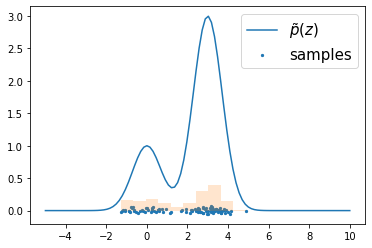

In [6]:
# plot
samples = metropolis_hastings(func, Gaussian(mu=np.ones(1), var=np.ones(1)), n=100, downsample=10)
plt.plot(x, func(x), label=r"$\tilde{p}(z)$")
plt.hist(samples, density=True, alpha=0.2)
plt.scatter(samples, np.random.normal(scale=.03, size=(100, 1)), s=5, label="samples")
plt.legend(fontsize=15)
plt.show()

# 11.3 吉布斯采样

Gibbs采样(Geman and Geman, 1984)是一个简单的并且广泛应用的马尔科夫链蒙特卡罗算法，可以被看做Metropolis-Hastings算法的一个具体的情形。
考虑我们想采样的概率分布$ p(z) = p(z_1,...,z_M) $，并且假设我们已经选择了马尔科夫链的某个初始的状态。Gibbs采样的每个步骤涉及到将一个变量的值替换为以剩余变量的值为条件，从这个概率分布中抽取的那个变量的值。因此我们将$ z_i $替换为从概率分布$ p(z_i|z_{\i}) $中抽取的值，其中$ z_i $表示$ z $的第$ i $个元素，$ z_{\i} $表示$ z_1,...,z_M $去掉$ z_i $这一项。这个步骤要么按照某种特定的顺序在变量之间进行循环，要么每一步中按照某个概率分布随机地选择一个变量进行更新。
例如，假设我们有一个在三个变量上的概率分布$ p(z_1, z_2, z_3) $，在算法的第$ \tau $步，我们已经选择了$ z_1^{(\tau)}, z_2^{(\tau)}, z_3^{(\tau)} $的值。首先，我们将$ z_1^{(\tau)} $替换为新值$ z_1^{(\tau + 1)} $，这个新值是从条件概率分布
$ p(z_1|z_2^{(\tau)},z_3^{(\tau)}) \tag{11.46} $
中采样得到的。接下来，我们将$ z_2^{(\tau)}) $替换为$ z_2^{(\tau + 1)}) $，这个新值是从条件概率分布
$ p(z_2| z_1^{(\tau + 1)}), z_3^{(\tau)})) \tag{11.47} $
中采样得到的，即$ z_1 $的新值可以在接下来的采样步骤中直接使用。然后，我们使用样本$ z_3^{(\tau + 1)})) $更新$ z_3 $，其中$ z_3^{(\tau + 1)})) $是从
$ p(z_3| z_1^{(\tau + 1)}), z_2^{(\tau + 1)})) \tag{11.48} $
中抽取的。以此类推，在这三个变量之间进行循环。
1.	初始化$ {z_i:i = 1,...,M} $。
2.	对于$ \tau = 1,...,T $:
•	采样$ z_1^{(\tau+1)} \sim p(z_1| z_2^{(\tau)},z_3^{(\tau)},...,z_M^{(\tau)}) $。
•	采样$ z_2^{(\tau+1)} \sim p(z_2| z_1^{(\tau + 1)},z_3^{(\tau)},...,z_M^{(\tau)}) $。
•	$ \vdots $
•	采样$ z_j^{(\tau+1)} \sim p(z_j| z_1^{(\tau + 1)},...,z_{j-1}^{(\tau + 1)},z_{j+1}^{(\tau)},...,z_M^{(\tau)}) $。
•	$ \vdots $
•	采样$ z_M^{(\tau+1)} \sim p(z_M| z_1^{(\tau + 1)},z_2^{(\tau + 1)},...,z_{M - 1}^{(\tau + 1)}) $。
为了证明这个步骤能够从所需的概率分布中采样，我们首先注意到对于Gibbs采样的每个步骤来说，概率分布$ p(z) $是不变的，因此对于整个马尔科夫链来说也是不变的。这是由于当我们从$ p(z_i|z_{\i}) $中采样时，边缘概率分布$ p(z_{\i}) $显然是不变的，因为$ z_{\i} $的值是不变的。并且，根据定义，对于每个步骤中来自正确条件概率分布$ p(z_i|z_{\i}) $的样本，条件概率分布都是不变的。由于条件概率分布和边缘概率分布共同确定的联合概率分布，因此我们看到联合概率分布本身是不变的。
为了让Gibbs采样能够从正确的概率分布中得到样本，第二个需要满足的要求为各态历经性。各态历经性的一个充分条件是没有条件概率分布处处为零。如果这个要求满足，那么$ z $空间中的任意一点都可以从其他的任意一点经过有限步骤达到，这些步骤中每次对一个变量进行更新。如果这个要求没有满足，即某些条件概率分布为0，那么在这种情况下应用Gibbs采样时，必须显式地证明各态历经性。
为了完成算法，初始状态的概率分布也应该被指定，虽然在多轮迭代之后，样本与初始状态的分布无关。当然，马尔科夫链中的连续的样本是高度相关的，因此为了得到近似独立的样本，需要对序列进行下采样。
我们可以将Gibbs采样步骤看成Metropolis-Hastings算法的一个特定的情况，如下所述。考虑一个Metropolis-Hastings采样的步骤，它涉及到变量$ z_k $，同时保持剩余的变量$ Z_{\k} $不变，并且对于这种情形来说，从$ Z $到$ Z^* $的转移概率为$ q_k(Z^|Z) = p(z_k^|Z_{\k}) $。我们注意到$ Z_{\k}^* = Z_{\k} $，因为在采样的步骤中，向量的各个元素都不改变。并且，$ p(Z) = p(z_k|Z_{\k})p(Z_{\k}) $。因此，确定Metropolis-Hastings算法中的接受概率的因子（11.44）为
$ A(Z^,Z) = \frac{p(Z^)q_k(Z|Z^)}{p(Z)q_k(Z^|Z)} = \frac{p(z_k^|Z_{\k}^)p(Z_{\k}^)p(z_k|Z_{\k}^)}{p(z_k|Z_{\k})p(Z_{\k})p(z_k|Z_{\k})} = 1 \tag{11.49} $
推导时我们用到了$ z_{\k}^* = z_{\k} $。因此Metropolis-Hastings步骤总是被接受的。 与Metropolis算法一样，我们可以通过研究Gibbs采样算法在高斯分布上的应用，更深刻的认识算法的原理。考虑两个相关变量上的一个高斯分布，如图11.11所示。
 
图 11.11 通过交替更新两个变量的方式进行Gibbs采样。这两个变量服从一个相关的高斯分布。步长由条件概率分布（绿色曲线）的标准差控制，值为$ O(l) $。在联合概率分布较长的方向上的速度很慢。得到这个分布的独立样本所需的步骤数量为$ O((L/l)^2) $。
这个高斯分布的条件概率分布的宽度为$ l $，边缘概率分布的宽度为$ L $。典型的步长由条件概率分布确定，从而量级为 $ l $。由于状态按照随机游走的方式进行转移，因此得到这个分布中的独立样本所需的步骤数量的量级为$ (L/l)^2 $。当然，如果高斯分布不是相关的，那么Gibbs采样的效率是最高的。对于这个简单的问题，我们可以将坐标系旋转，从而解除变量之间的相关关系。然而，在实际应用中，通常找到这种变换是不可行的。
一种减小Gibbs采样过程中的随机游走行为的方法被称为过松弛（over-relaxation）（Adler， 1981）。在这种方法的最初的形式中，它被用于处理条件概率分布是高斯分布的情形，这种情形要比多元高斯分布更一般，因为诸如非高斯分布$ p(z, y) \proto exp(−z^2y^2) $具有高斯条件分布的形式。在Gibbs采样算法的每个步骤中，对于一个特定的分量$ z_i $，条件概率分布具有均值$ \mu_i $和方差$ \sigma_i^2 $。在过松弛框架中，$ z_i $被替换为
$ z_i' = \mu_i + \alpha(z_i - \mu_i) + \sigma_i(1 - \alpha^2)^{1/2}\nu \tag{11.50} $
其中$ \nu $是一个高斯随机变量，均值为0，方差为1，$ \alpha $是一个满足$ −1 < \alpha < 1 $的参数。对于$ \alpha = 0 $的情形，方法等价于标准的Gibbs采样，对于$ \alpha < 0 $，步骤会偏向于与均值相反的一侧。这个步骤使得所求的概率分布具有不变性，因为如果$ z_i $的均值为$ \mu_i $，方差为$ \sigma_i^2 $，那么$ z_i' $也是。过松弛的效果是当变量高度相关时，鼓励在状态空间中的直接移动。有序过松弛（ordered over-relaxation）框架(Neal，1999)将这种方法推广到了非高斯分布的情形。
Gibbs采样的实际应用依赖于哪个样本可以从条件概率分布$ p(z_k | z_{\k}) $中抽取。在概率分布使用图模型表示的情况下，各个结点的条件概率分布只依赖于对应的马尔科夫毯中的变量，如图11.12所示。
 
图 11.12 Gibbs采样方法要求样本从一个变量的条件概率分布中抽取，条件是其他的变量。对于图模型来说，条件概率分布只是马尔科夫毯中的结点状态的函数。对于无向图来说，马尔科夫毯由相邻结点的集合组成，如左图所示。而对于有向图来说，马尔科夫毯由父结点、子结点、同父结点组成，如右图所示。
对于有向图来说，以某个结点的父结点为条件，这个结点的一大类条件概率分布 都会使得用于Gibbs采样的概率分布是对数凹函数。于是，11.1.3节讨论的可调节拒绝采样方法提供了有向图的蒙特卡罗采样方法的一个框架，这种方法具有广泛的适用性。
如果图是使用指数族分布构建的，并且父结点-子结点关系保持共轭，那么Gibbs采样中的完整的条件概率分布会与定义在每个结点的原始的条件概率分布（以父结点为条件）具有相同的函数形式，因此可以使用标准的采样方法。通常，完整的条件概率分布的形式会很复杂，从而无法使用标准的采样方法。然而，如果这些条件概率分布是对数凹函数，那么使用可调整的拒绝采样方法，采样可以高效地完成（假设对应的变量是标量）。
如果在Gibbs采样算法的每个阶段，我们不从对应的条件概率分布中抽取样本，而是对变量进行一个点估计，这个点估计由条件概率分布的最大值给出，那么我们就得到了8.3.3节讨论的迭代条件峰值(ICM)算法。因此，ICM可以看成是Gibbs采样的一种贪心近似。
由于基本的Gibbs采样方法每次只考虑一个变量，因此它在连续样本之间具有很强的依赖性。在另一个极端情况下，如果我们直接从联合概率分布中采样（我们一直假定这种操作无法完成），那么连续的样本点之间就是独立的。我们可以采用一种折中的方法来提升简单的Gibbs采样的效果，即我们连续地对一组变量进行采样，而不是对一个变量进行采样。这就是分块Gibbs（blocking Gibbs）采样算法。这种算法中，将变量集合分块（未必互斥），然后在每个 块内部联合地采样，采样时以剩余的变量为条件(Jensen et al.，1995)。



# 11.4 切片采样

我们已经看到，Metropolis算法的一个困难之处是它对于步长的敏感性。如果步长过小，那么由于随机游走行为，算法会很慢。而如果步长过大，那么由于较高的拒绝率，算法会很低效。切片采样（slice sampling）方法（Neal， 2003）提供了一个可以自动调节步长来匹配分布特征的方法。同样的，它需要我们能够计算未标准化的概率分布$ \tilde{p}(z) $。
首先考虑一元变量的情形。切片采样涉及到使用额外的变量$ u $对$ z $进行增广，然后从联合的$ (z, u) $空间中采样。当我们在11.5节讨论混合蒙特卡罗方法时，我们会看到这种方法的另一个例子。目标是从下面的概率分布
$ \hat{p}(z,u) = \begin{cases} 1 / Z_p if 0 \leq u \leq \tilde{p}(z) 0, otherwise \end{cases} \tag{11.51} $
中均匀地进行采样，其中$ Z_p = \tilde{p}(z)dz $。$ z $上的边缘概率分布为
$ \int\hat{p}(z,u)du = \int_0^{\tilde{p}(z)}\frac{1}{Z_p}du = \frac{\tilde{p}(z)}{Z_p} = p(z) \tag{11.52} $
因此，我们可以通过从$ \hat{p}(z,u) $中采样，然后忽略$ u $值的方式得到$ p(z) $的样本。通过交替的对$ z $和$ u $进行采样即可完成这一点。给定$ z $的值，我们可以计算$ \tilde{p}(z) $的值，然后在$ 0 \leq u \leq \tilde{p}(z) $上均匀的对$ u $进行采样，这很容易。然后，我们固定$ u $，在由$ {z:\tilde{p}(z) > u} $定义的分布的“切片”上，对$ z $进行均匀的采样。图11.13(a)给出了说明。
 
图 11.13 切片采样的例子。(a)对于给定的$ z^{(\tau)} $，$ u $的值从$ 0 \leq u \leq \tilde{p}(z^{(\tau)}) $区域中均匀采样，它之后定义了穿过这个概率分布的一个“切片”。(b)由于直接从切片中采样是不可行的，因此$ z $的一个新的样本被从区域$ z_{\min} \leq z \leq z_{\max} $中抽取，它包含了前一个值$ z^{(\tau)} $。
在实际应用中，直接从穿过概率分布的切片中采样很困难，因此我们定义了一个采样方法，它保持$ \hat{p}(z,u) $下的均匀分布具有不变性，这可以通过确保满足细节平衡的套件来实现。假设$ z $的当前值记作$ z^{(\tau)} $，且我们已经得到了一个对应的样本$ u $。$ z $的下一个值可以通过考察包含$ z^{(\tau)} $的区域$ z_\min \leq z \leq z_\max $来获得。根据概率分布的特征长度标度来对步长进行的调节就发生在这里。我们希望区域包含尽可能多的切片，从而使得$ z $空间中能进行较大的移动，同时希望切片外的区域尽可能小，因为切片外的区域会使得采样变得低效。
一种选择区域的方法是，从一个包含$ z^{(\tau)} $的具有某个宽度$ w $的区域开始，然后测试每个端点，看它们是否位于切片内部。如果有端点没在切片内部，那么区域在增加$ w $值的方向上进行扩展，知道端点位于区域外。然后，$ ' $的一个样本被从这个区域中均匀抽取。如果它位于切片内，那么它就构成了$ z^{(\tau
•	1)} $。如果它位于切片外，那么区域收缩，使得$ z' $组成一个端点，并且区域仍然包含$ z^{(\tau)} $。然后，另一个样本点从这个缩小的区域中均匀抽取，以此类推，直到找到位于切片内部的一个$ z $值。
切片采样可以应用于多元分布中，方法是按照Gibbs采样的方式重复地对每个变量进行采样。这要求对于每个元素$ z_i $，我们能够计算一个正比于$ p(z_i | z_{\i}) $的函数。



# 11.5 混合蒙特卡洛算法

正如我们已经注意到的那样，Metropolis算法的一个主要的局限是它具有随机游走的行为，而在状态空间中遍历的距离与步骤数量只是平方根的关系。仅仅通过增大步长的方式是无法解 决这个问题的，因为这会使得拒绝率变高。

本节中，我们介绍一类更加复杂的转移方法。这些方法基于对物理系统的一个类比，能够让系统状态发生较大的改变，同时让拒绝的概率较低。它适用于连续变量上的概率分布，对于连续变量，我们已经能够计算对数概率关于状态变量的梯度。我们会在11.5.1节讨论动态系统框架，然后在11.5.2节，我们会解释这个框架如何与Metropolis算法结合，产生出一个强大的混合蒙特卡罗算法。这里不需要物理学的背景，因为本节是自洽的，并且关键的结果全部从基本的原理中推导出。

## 11.5.1 动态系统

随机采样的动态方法起源于模拟哈密顿动力学下进行变化的物理系统的行为。在马尔科夫链 蒙特卡罗模拟中，目标是从一个给定的概率分布$ p(z) $中采样。通过将概率仿真转化为哈密顿系统的形式，我们可以利用哈密顿动力学（Hamiltonian dynamics）的框架。为了与这个领域的文献保持一致，我们在必要的时候会使用相关动态系统的术语，这些术语会随着我们内容的推进而给出定义。 我们考虑的动力学对应于在连续时刻（记作$ \tau $）下的状态变量$ Z = {z_i} $的演化。经典的动力学由牛顿第二定律描述，即物体的加速度正比于施加的力，对应于关于时间的二阶微分方程。我们可以将一个二阶微分方程分解为两个相互偶合的一阶方程，方法是引入中间的动量（momentum）变量$ r $，对应于状态变量$ z $的变化率，元素为
$ r_i = \frac{dz_i}{d\tau} \tag{11.53} $
从动力学的角度，$ z_i $可以被看做位置（position）变量。因此对于每个位置变量，都存在一个对应的动量变量，位置和动量组成的联合空间被称为相空间（phase space）。
不失一般性，我们可以将概率分布$ p(z) $写成下面的形式
$ p(z) = \frac{1}{Z_p}exp(-E(z)) \tag{11.54} $
其中$ E(z) $可以看做状态$ z $处的势能（potential energy）。系统的加速度是动量的变化率，通过施加力（force）的方式确定，它本身是势能的负梯度，即
$ \frac{dr_i}{d\tau} = -\frac{\partial E(z)}{\partial z_i} \tag{11.55} $
使用哈密顿框架重新写出这个动态系统的公式是比较方便的。为了完成这一点，我们首先将动能（kinetic energy）定义为
$ K(r) = \frac{1}{2}\Vert r \Vert^2 = \frac{1}{2}\sum\limits_i r_i^2 \tag{11.56} $
系统的总能量是势能和动能之和，即
$ H(z,r) = E(z) + K(r) \tag{11.57} $
其中$ H $是哈密顿函数（Hamiltonian function）。使用式（11.53）、（11.55）、（11.56）和（11.57），我们现在可以将系统的动力学用哈密顿方程的形式表示出来，形式为
$ \begin{eqnarray} \frac{dz_i}{d\tau} = \frac{\partial H}{\partial r_i} \tag{11.58} \ \frac{dr_i}{d\tau} = \frac{\partial H}{\partial z_i} \tag{11.59} \end{eqnarray} $
在动态系统的变化过程中，哈密顿函数$ H $的值是一个常数，这一点通过求微分的方式很容易看出来。
$ \begin{eqnarray} \frac{dH}{d\tau} &=& \sum\limits_i\left{\frac{\partial H}{\partial z_i}\frac{dz_i}{d\tau} + \frac{\partial H}{\partial r_i}\frac{dr_i}{d\tau}\right} \ &=& \sum\limits_i\left{\frac{\partial H}{\partial z_i}\frac{\partial H}{\partial r_i} - \frac{\partial H}{\partial r_i}\frac{\partial H}{\partial z_i}\right} = 0 \tag{11.60} \end{eqnarray} $
哈密顿动态系统的第二个重要性质是动态系统在相空间中体积不变，这被称为Liouville定理（Liouville's Theorem）。也就是说，如果我们考虑变量$ (z, r) $空间中的一个区域，那么当这个区域在哈密顿动态方程下的变化时，它的形状可能会改变，但是它的体积不会改变。可以这样证明：我们注意到流场（位置在相空间的变化率）为
$ V = \left(\frac{dz}{d\tau}, \frac{dr}{d\tau}\right) \tag{11.61} $
这个场的散度为0，即
$ \begin{eqnarray} div V &=& \sum\limits_i\left{\frac{\partial}{\partial z_i}\frac{dz_i}{d\tau} + \frac{\partial}{\partial r_i}\frac{dr_i}{d\tau}\right} \ &=& \sum\limits_i\left{+\frac{\partial}{\partial z_i}\frac{\partial H}{\partial r_i} - \frac{\partial}{\partial r_i}\frac{\partial H}{\partial z_i}\right} = 0 \tag{11.62} \end{eqnarray} $
现在考虑相空间上的联合概率分布，它的总能量是哈密顿函数，即概率分布的形式为
$ p(z,r) = \frac{1}{Z_H}exp(-H(z,r)) \tag{11.63} $
使用体系的不变性和$ H $的守恒性，可以看到哈密顿动态系统会使得$ p(z, r) $保持不变。可以这样证明：考虑相空间的一个小区域，区域中$ H $近似为常数。如果我们跟踪一段有限时间内的哈密顿方程的变化，那么这个区域的体积不会发生改变，从而这个区域的$ H $的值不会发生改变，因此概率密度（只是$ H $的函数）也不会改变。
虽然$ H $是不变的，但是$ z $和$ r $会发生变换，因此通过在一个有限的时间间隔上对哈密顿动态系统积分，我们就可以让$ z $以一种系统化的方式发生较大的变化，避免了随机游走的行为。
然而，哈密顿动态系统的变化对$ p(z, r) $的采样不具有各态历经性，因为$ H $的值是一个常数。为了得到一个具有各态历经性的采样方法，我们可以在相空间中引入额外的移动，这些移动会改变$ H $的值，同时也保持了概率分布$ p(z, r) $的不变性。达到这个目标的最简单的方式是将$ r $的值替换为一个从以$ z $为条件的概率分布中抽取的样本。这可以被看成Gibbs采样的步骤，因此根据11.3节，我们看到这也使得所求的概率分布保持了不变性。注意，$ z $和$ r $在概率分布$ p(z, r) $中是独立的，我们看到条件概率分布$ p(r|z) $是高斯分布，从中我们可以很容易地进行采样。
在这种方法的一个实际应用中，我们必须解决计算哈密顿方程的数值积分的问题。这会引入一些数值的误差，因此我们要设计一种方法来最小化这些误差产生的影响。事实上，可以证明，能够在Liouville定理仍然精确成立的条件下，对积分方法进行修改。这个性质在11.5.2节讨论混合蒙特卡罗算法时很重要。完成这件事的一种方法是蛙跳（leapfrog）离散化。这种方法使用下面的公式对位置变量和动量变量的离散时间近似$ z $和$ r $进行交替地更新。
$ \begin{eqnarray} \hat{r}_i\left(\tau + \frac{\epsilon}{2}\right) &=& \hat{r}_i(\tau) - \frac{\epsilon}{2}\frac{\partial E}{\partial z_i}(\hat{z}(r)) \tag{11.64} \ \hat{z}_i(\tau + \epsilon) &=& \hat{z}_i(\tau) + \epsilon\hat{r}_i\left(\tau + \frac{\epsilon}{2}\right) \tag{11.65} \ \hat{r}_i(\tau + \epsilon) &=& \hat{r}_i\left(\tau + \frac{\epsilon}{2}\right) - \frac{\epsilon}{2}\frac{\partial E}{\partial z_i}(\hat{z}(\tau + \epsilon)) \tag{11.66} \end{eqnarray} $
我们看到，这种方法对动量变量的更新形式是半步更新，步长为$ \epsilon $，接着是对位置变量的整步更新，步长为$ \epsilon $，然后是对动量变量的第二个半步更新。如果我们连续地使用几次蛙跳，那么可以看到，对动量变量的半步更新可以结合到步长为$ \epsilon $的整步更新中。于是，位置变量的更新和动量变量的更新互相之间以蛙跳的形式结合。为了将动态系统跪进一个时间间隔$ \tau $，我们需要进行$ \tau / \epsilon $个步骤。对连续时间动态系统的离散化近似引入的误差会在极限$ \epsilon \to 0 $的情况下趋于0，假设函数$ E(Z) $是光滑的。然而，对于实际应用中使用的一个非零的$ \epsilon $，一些保留的误差仍然会存在。我们会在11.5.2节看到在混合蒙特卡罗算法中，这些误差的影响如何被消除。
总结一下，哈密顿动力学方法涉及到交替地进行一系列蛙跳更新以及根据动量变量的边缘分布进行重新采样。
注意，与基本的Metropolis方法不同，哈密顿动力学方法能够利用对数概率分布的梯度信息以及概率分布本身的信息。在函数最优化领域有一个类似的情形。大多数可以得到梯度信息的情况下，使用哈密顿动力学方法是很有优势的。非形式化地说，这种现象是由于下面的事实造成的：在$ D $维空间中，与计算函数本身的代价相比，计算梯度所带来的额外的计算代价通常是一个与$ D $无关的固定因子。而与函数本身只能传递一条信息相比，$ D $维梯度向量可以传递$ D $条信 息。



## 11.5.2 混合蒙特卡洛方法

正如我们在前一节讨论的那样，对于一个非零的步长$ \epsilon $，蛙跳算法的离散化会在哈密顿动力学方程的积分过程中引入误差。混合蒙特卡罗（hybrid Monte Carlo）（Duane et al.， 1987; Neal， 1996）将哈密顿动态系统与Metropolis算法结合在一起，因此消除了与离散化过程关联的任何偏差。 具体来说，算法使用了一个马尔科夫链，它由对动量变量r的随机更新以及使用蛙跳算法对哈密顿动态系统的更新交替组成。在每次应用蛙跳算法之后，基于哈密顿函数$ H $的值，确定Metropolis准则，确定生成的候选状态被接受或者拒绝。因此，如果$ (z, r) $是初始状态，$ (z^, r^) $是蛙跳积分后的状态，那么候选状态被接受的概率为
$ \min(1,exp{H(z,r) - H(z^,r^)}) \tag{11.67} $
如果蛙跳积分完美地模拟了哈密顿动态系统，那么每个这种候选状态都会自动地被接受，因为$ H $的值会保持不变。由于数值误差，$ H $的值有时可能会减小，因此我们希望Metropolis准则将这种效果引发的任何偏差都消除，并且确保得到的样本确实是从所需的概率分布中抽取的。为了完成这件事，我们需要确保对应于蛙跳积分的更新方程满足细节平衡（11.40）。通过按照下 面的方式修改蛙跳方法，这个目标很容易实现。
在开始蛙跳积分序列之前，我们等概率地随机选择是沿着时间向前的方向积分（步长为$ \epsilon $）还是沿着时间向后的方向积分（步长为$ −\epsilon $）。我们首先注意到，蛙跳积分方法（11.64）、 （11.65）和（11.66）是时间可翻转的，即$ L $步使用步长为$ −\epsilon $的积分会抵消L步使用步长为\epsilon的积分。接下来我们证明蛙跳积分精确地保持了相空间的体积不变性。这是因为，蛙跳方法中的每一步对$ z_i $或$ r_i $的更新都只是另一个变量的函数。如图11.14所示，这个现象产生的效果是将相空间的一个区域进行形变而不改变它的体积。
 
图 11.14 蛙跳算法（11.64）到（11.66）中的每一步修改位置变量$ z_i $或动量变量$ r_i $中的一个。由于对一个变量的修改只是另一个变量的函数，因此相空间的任意区域在形变时不会改变体积。
最后，我们使用这些结果证明细节平衡是成立的。考虑相空间的一个小区域$ R $，它在$ L $次步长为$ \epsilon $的蛙跳迭代序列之后被映射到了区域$ R' $。使用在蛙跳迭代下的体积的不变性，我们看到如果$ R $的体积为$ \delta V $，那么$ R' $的体积也是。如果我们从概率分布（11.63）中选择一个初始点，然后使用$ L $次蛙跳进行更新，那么从区域$ R $转移到$ R' $的概率为
$ \frac{1}{Z_H}exp(-H(R))\delta V\frac{1}{2}\min{1,exp(H(R) - H(R'))} \tag{11.68} $
其中，因子$ 1 / 2 $来自于选择用一个正的步长而不是负的步长进行积分的概率。类似地，从区域$ R' $开始，沿着时间的反方向回到区域$ R $的概率为
$ \frac{1}{Z_H}exp(-H(R'))\delta V\frac{1}{2}\min{1,exp(H(R') - H(R))} \tag{11.69} $
很容易看到，两个概率（11.68）和（11.69）是相等的，因此满足细节平衡。注意，这个证明忽略了区域$ R $和$ R' $之间有重叠的情况，但是很容易进行推广使其适用于这种存在重叠的情形。
不难构造蛙跳算法在有限次迭代之后返回起始点的例子。在这种情况下，每次蛙跳迭代之前对动量值的随机替换对确保各态历经性是不充分的，因为位置变量永远不会被更新。通过在蛙跳积分之前随机地从某个小区间中选择步长的大小，这种现象很容易避免。
通过考察混合蒙特卡罗算法在多元高斯分布上的应用，我们可以更深刻地理解算法的行为。为了方便，考虑具有独立分量的高斯分布$ p(z) $，它的哈密顿函数为
$ H(z,r) = \frac{1}{2}\sum\limits_i\frac{1}{\sigma_i^2}z_i^2 + \frac{1}{2}\sum\limits_ir_i^2 \tag{11.70} $
我们的结论对于分量之间具有相关性的高斯分布同样适用，因为混合蒙特卡罗算法具有旋转不变性。在蛙跳积分阶段，每对相空间变量$ z_i, r_i $独立变化。然而，对候选样本点接受或是拒绝基于的是$ H $的值，它依赖于所有变量的值。因此，任何变量的一个较大的积分误差会产生一个较高的拒绝概率。为了让离散蛙跳积分对真实的连续时间动态系统产生一个较好的近似，有必要让蛙跳积分的标度$ \epsilon $小于势函数变化的最短的长度标度。这由$ \sigma_i $的最小值控制，我们将其记作$ \sigma_\min $。回忆一下，混合蒙特卡罗算法中的蛙跳积分的目标是在相空间中移动较大的距离到达新状态，这个新状态与初始状态相对独立，同时还能达到较高的接受率。为了实现这个目标，蛙跳积分必须连续进行多次迭代，迭代的次数是$ \sigma_\max / \sigma_\min $的量级。
相反，考虑之前讨论过的一个简单的Metropolis算法的行为，它具有各向同性的高斯提议分布，方差为$ s^2 $。为了避免高拒绝率，$ s $的值必须设置为$ \sigma_\min $的量级。这样，对状态空间的探索通过随机游走的方式进行，达到近似独立的状态所需的步骤数是$ (\sigma_\max / \sigma_\min)^2 $量级的。



# 11.6 估计划分函数

正如我们已经看到的，本章中讨论的大部分采样算法只需要概率分布的函数形式，忽略一个 可乘的常数。因此，如果我们有
$ p_E(z) = \frac{1}{Z_E}exp(-E(z)) \tag{11.71} $
那么为了从$ p(z) $中采样，标准化常数$ Z_E $的值（也被称为划分函数）是不需要的。然而，关于$ Z_E $的信息对于贝叶斯模型比较是有用的，因为它表示模型证据（即观测数据能够生成模型的概率），因此我们对它的值如何得到很感兴趣。我们假设在$ z $的状态空间中，对函数$ exp(−E(z)) $求和或积分是不可行的。
对于模型比较来说，我们所需的实际是两个模型的划分函数的比值。将这个比值与先验概率的比值相乘可以得到后验概率的比值。之后可以用这个比值来进行模型选择或者模型平均。
一种估计划分函数比值的方法是使用概率分布的重要采样，这个概率分布的能量函数 为$ G(z) $，即
$ \begin{eqnarray} \frac{Z_E}{Z_G} &=& \frac{\sum_zexp(-E(x))}{\sum_zexp(-G(z))} \ &=& \frac{\sum_zexp(-E(z) + G(z))exp(-G(z))}{\sum_zexp(-G(z))} \ &=& \mathbb{E}_{G(z)}[exp(-E + G)] \ &\simeq& \frac{1}{L}\sum\limits_l exp(-E(z^{(l)}) + G(z^{(l)})) \tag{11.72} \end{eqnarray} $
其中$ {z^{(l)}} $是从$ pG(z) $定义的概率分布中抽取的样本。如果概率分布$ pG $的划分函数可以解析地计算，例如它是一个高斯分布，那么$ Z_E $的绝对值可以得到。
如果重要采样分布$ pG $很好地匹配概率分布$ pE $，即比值$ pE/pG $变化不大，那么这种方法会产生准确的结果。在实际应用中，对于本书中考察的复杂的模型，我们无法找到一个可以很容易地解析计算的重要采样分布。
于是,另一种方法是使用从马尔科夫链中得到的样本来定义重要采样分布。如果马尔科夫链的转移概率为$ T(z, z') $，样本集合为$ z^{(1)},...,z^{(L)} $，那么采样分布可以写成
$ \frac{1}{Z_G}exp(-G(z)) = \frac{1}{L}\sum\limits_{l=1}^LT(z^{(l)}, z) \tag{11.73} $
这可以直接应用于式（11.72）。
计算两个划分函数的比值的方法需要对应的概率分布较好地匹配。如果我们希望找到一个复杂的概率分布的划分函数的绝对的值，那么这是一个很大的问题，因为只有对于相对简单的概率分布才能够直接计算划分函数，因此尝试直接估计划分函数的比值是无法完成的。使用链（chaining）方法，这个问题可以解决(Neal, 1993; Barber and Bishop, 1997)。这种方法涉及到 连续引入中间分布$ p_2,...,p_{M−1} $，这些分布是在我们可以计算标准化系数Z1的简单分布$ p_1(z) $和所求的复杂概率分布$ p_M(z) $之间进行的内插。于是我们有
$ \frac{Z_M}{Z_1} = \frac{Z_2}{Z_1} \frac{Z_3}{Z_2} \dots \frac{Z_M}{Z_{M-1}} \tag{11.74} $
其中,中间的比值可以使用蒙特卡罗算法进行确定,与之前讨论的一样。一种建立中间系统序 列的方法是使用一个包含连续参数0 ≤ α ≤ 1的势函数,在两个概率分布之间进行内插,即
$ E_\alpha(z) = (1-\alpha)E_1(z) + \alpha E_M(z) \tag{11.75} $
如果式（11.74）中的中间比值使用蒙特卡罗算法得到，那使用一个单一的马尔科夫链可能要相对于每个比值都重新设置一个马尔科夫链的方式可能更高效。在这种情况下，马尔科夫链初始时设置为系统$ p_1 $，然后在某个合适的迭代次数之后，移到序列中的下一个概率分布。然而需要注意的是，系统必须在每个阶段保持与均衡分布接近。

